In [4]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import time
import tqdm
import glob
import torch
import librosa
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal

import dcase_dataset
import sed_utils
import models
import explore
import post_processing as pp
import evaluate_model
import dcase_evaluation
import stats_utils
import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = models.get_model('resnet', 48, 16, 1024, 64, 1)
print("Number of parameters: ", count_parameters(model))


Number of parameters:  1732992


# Ensamble + Adaptive network predictions

In [2]:
def ensemble_prediction(csv_path, experiment_dir, tfs=[], runs=[], thrs=[], adaptive_embedding=False, window_size=None, hop_size_fraction=2):
    n_shot = 5
    
    window_sizes = np.array([2048, 4096, 8192, 16384])
    #window_sizes = np.array([4096, 8192, 16384])

    
    # use correct model
    if adaptive_embedding:
        n_shot_event_lengths = stats_utils.get_nshot_event_lengths(n_shot, csv_path)
        average_event_length = np.min(n_shot_event_lengths) / 2
        average_event_size = int(sample_rate * average_event_length)
        window_size = window_sizes[np.argmin(np.sqrt(np.power(window_sizes-average_event_size, 2)))]
        hop_size = window_size // hop_size_fraction
    else:
        window_size = window_size #window_sizes[2]
        hop_size    = window_size // hop_size_fraction
        #window_size = valid_conf['window_size']
        
    #print("csv_path = {}, window_size = {}, hop_size = {}".format(csv_path, window_size, hop_size))
    
    # TODO: rewrite this a bit to loop over tfs and runs and create paths
    experiment_paths = []
    for tf in tfs:
        for run in runs:
            experiment_path = os.path.join(experiment_dir, tf, 'window_size_{}'.format(window_size), 'run_{}'.format(run))
            experiment_paths.append(experiment_path)
    #print(experiment_paths)
    
    y_predss = []
    for experiment_path in experiment_paths: # ensamble predictions
        # load the predictions
        basename        = os.path.basename(csv_path).split('.')[0]
        prediction_path = os.path.join(experiment_path, 'predictions', '{}_predictions_hop_size_{}.npy'.format(basename, hop_size))
        times_path      = os.path.join(experiment_path, 'predictions', '{}_times_hop_size_{}.npy'.format(basename, hop_size))

        if os.path.exists(prediction_path):
            y_preds = np.load(prediction_path)
            q_times = np.load(times_path)
        else:
            raise ValueError("predictions are missing: ", prediction_path)
        y_predss.append(np.expand_dims(np.array(y_preds), axis=0))
    y_predss = np.concatenate(y_predss, axis=0)
    y_preds  = np.mean(y_predss, axis=0)
    
    sorted_predicitions, sorted_intervals = zip(*sorted(list(zip(y_preds, q_times)), key=lambda x: x[1][0]))
    
    ann_df = pd.read_csv(csv_path)
    ann_df = ann_df.sort_values(by='Starttime', axis=0, ascending=True)
    nth_event = evaluate_model.select_nth_event_with_value(ann_df, 5, value='POS')
    skiptime = nth_event['Endtime']
    
    # evaluate for different thresholds
    set_pos_events = {}
    for thr in thrs:
        set_pos_events[thr] = []

    for thr in thrs:
        binary_predictions = np.zeros(len(sorted_predicitions))

        for idx in range(len(sorted_intervals)):
            y_proba = sorted_predicitions[idx]
            if y_proba > thr:
                binary_predictions[idx] = 1

        # apply a median filter
        binary_predictions = scipy.signal.medfilt(binary_predictions, 1)

        for pred, interval in zip(binary_predictions, sorted_intervals):
            if pred == 1 and not interval[0] < skiptime:
                    filename = os.path.basename(csv_path).replace('.csv', '.wav')
                    set_pos_events[thr].append({
                        'Audiofilename' : filename,
                        'Starttime'     : interval[0],
                        'Endtime'       : interval[1],
                    })
    
    return set_pos_events

def ensemble_set_prediction(csv_paths, experiment_dir, tfs, runs, thrs, adaptive_embedding=False, window_size=None, hop_size_fraction=2):
    set_pos_events = {}
    for thr in thrs:
        set_pos_events[thr] = []

    for csv_path in csv_paths:
        #print(csv_path)
        csv_pos_events = ensemble_prediction(
            csv_path       = csv_path, 
            experiment_dir = experiment_dir, 
            tfs            = tfs,
            runs           = runs,
            thrs           = thrs, 
            adaptive_embedding=adaptive_embedding,
            window_size    = window_size,
            hop_size_fraction=hop_size_fraction,
        )
        #print(csv_pos_events)

        for thr in thrs:
            for pos_event in csv_pos_events[thr]:
                set_pos_events[thr].append(pos_event)
    return set_pos_events

In [6]:
def compute_scores(set_pos_events, thrs, sets, measures, prediction_path='test_pred_post_csv', run_evaluation=True):
    set_scores = {}
    for s in sets:
        set_scores[s] = {}
        for measure in measures:
            set_scores[s][measure] = []
            
    for thr in thrs:
        pos_events = set_pos_events[thr]

        y_pred_df = pd.DataFrame(pos_events)
        y_pred_df = pp.merge_predictions(y_pred_df)
        y_pred_df = pp.adaptive_remove_unmatchable_predictions(y_pred_df, csv_paths, 5)

        #pred_file_path = 'test_pred_post.csv'
        pred_file_path = prediction_path
        y_pred_df.to_csv(pred_file_path, index=False)
        
        if not os.path.exists('./evals'):
            os.makedirs('./evals')

        if run_evaluation:
            overall_scores, scores_per_subset = dcase_evaluation.evaluate(
                    pred_file_path = pred_file_path,
                    ref_file_path  = root_dir,
                    team_name      = "TeamGBG",
                    dataset        = 'VAL',
                    savepath       = './evals',
                    metadata       = [],
                    verbose        = False #True
            )

            for k in sets:
                for measure in measures:
                    if k == 'all':
                        score = overall_scores[measure]
                    else:
                        score = scores_per_subset[k][measure]
                    set_scores[k][measure].append(score)
    return set_scores

def evaluate_and_plot(configs, csv_paths, fig_path, prediction_path='test_pred_post_csv', run_evaluation=True):
    fig = plt.figure(figsize=(4, 3))
    for config in configs:
        thrs = config['thrs']
        runs = config['runs']
        tfs  = config['tfs']
        adaptive_embedding = config['adaptive_embedding']
        experiment_dir = config['experiment_dir']
        hop_size_fraction=config['hop_size_fraction']
        
        if not adaptive_embedding:
            window_size = config['window_size']
        else:
            window_size = None

        set_pos_events = ensemble_set_prediction(
            csv_paths          = csv_paths,
            experiment_dir     = experiment_dir,
            tfs                = tfs,
            runs               = runs,
            thrs               = thrs,
            adaptive_embedding = adaptive_embedding,
            window_size        = window_size,
            hop_size_fraction  = hop_size_fraction,
        )

        #print(set_pos_events)

        sets = ['HB', 'PB', 'ME', 'all']
        measures = ['f-measure', 'precision', 'recall']
        set_scores = compute_scores(set_pos_events, thrs, sets, measures, prediction_path=prediction_path, run_evaluation=run_evaluation)

        #plt.rcParams['text.usetex'] = True
        
        plt.rc('font', family='serif')
        plt.rc('xtick', labelsize='x-small')
        plt.rc('ytick', labelsize='x-small')

        if run_evaluation:
            plt.plot(thrs, set_scores['all']['f-measure'], label=config['label'])
            plt.xlabel('Threshold')
            plt.ylabel('F-score')
            print("{} max f-measure = {}".format(config['label'], np.max(set_scores['all']['f-measure'])))
    plt.legend()
    plt.savefig(fig_path)
    return fig

# Submissions

# Figure 2

/home/john/workspace/reproduce/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.13076923076923078, 'recall': 0.9807692307692307, 'fmeasure (percentage)': 23.077}
PB scores:  {'precision': 0.004029936672423719, 'recall': 0.056, 'fmeasure (percentage)': 0.752}
HB scores:  {'precision': 0.9871323529411765, 'recall': 0.8111782477341389, 'fmeasure (percentage)': 89.055}
ME scores:  {'precision': 0.31875, 'recall': 0.9807692307692307, 'fmeasure (percentage)': 48.113}
PB scores:  {'precision': 0.004687133817670494, 'recall': 0.08163265306122448, 'fmeasure (percentage)': 0.887}
HB scores:  {'precision': 0.9779005524861878, 'recall': 0.8021148036253777, 'fmeasure (percentage)': 88.133}
ME scores:  {'precision': 0.4336283185840708, 'recall': 0.9423076923076923, 'fmeasure (percentage)': 59.394}
PB scores:  {'precision': 0.007347972972972973, 'recall': 0.3702127659574468, 'fmeasure (percentage)': 1.441}
HB scores:  {'precision': 0.9721189591078067, 'recall': 0.7900302114803626, 'fmeasure (percentage)': 87.167}
ME scores:  {'precision': 0.4897959183

ME scores:  {'precision': 0.6515151515151515, 'recall': 0.8269230769230769, 'fmeasure (percentage)': 72.881}
PB scores:  {'precision': 0.6785714285714286, 'recall': 0.152, 'fmeasure (percentage)': 24.837}
HB scores:  {'precision': 0.8596491228070176, 'recall': 0.6661631419939577, 'fmeasure (percentage)': 75.064}
Prediction 1 max f-measure = 0.6330323833746836
ME scores:  {'precision': 0.21030042918454936, 'recall': 0.9423076923076923, 'fmeasure (percentage)': 34.386}
PB scores:  {'precision': 0.0026520802254268194, 'recall': 0.064, 'fmeasure (percentage)': 0.509}
HB scores:  {'precision': 0.9558823529411765, 'recall': 0.7854984894259819, 'fmeasure (percentage)': 86.235}
ME scores:  {'precision': 0.34532374100719426, 'recall': 0.9230769230769231, 'fmeasure (percentage)': 50.262}
PB scores:  {'precision': 0.004879953152449736, 'recall': 0.10638297872340426, 'fmeasure (percentage)': 0.933}
HB scores:  {'precision': 0.9537037037037037, 'recall': 0.7779456193353474, 'fmeasure (percentage)':

ME scores:  {'precision': 0.6351351351351351, 'recall': 0.9038461538461539, 'fmeasure (percentage)': 74.603}
PB scores:  {'precision': 0.3293172690763052, 'recall': 0.34893617021276596, 'fmeasure (percentage)': 33.884}
HB scores:  {'precision': 0.9457943925233645, 'recall': 0.7643504531722054, 'fmeasure (percentage)': 84.545}
ME scores:  {'precision': 0.6571428571428571, 'recall': 0.8846153846153846, 'fmeasure (percentage)': 75.41}
PB scores:  {'precision': 0.6944444444444444, 'recall': 0.20408163265306123, 'fmeasure (percentage)': 31.546}
HB scores:  {'precision': 0.9194139194139194, 'recall': 0.7583081570996979, 'fmeasure (percentage)': 83.113}
ME scores:  {'precision': 0.7894736842105263, 'recall': 0.8653846153846154, 'fmeasure (percentage)': 82.569}
PB scores:  {'precision': 0.5, 'recall': 0.048, 'fmeasure (percentage)': 8.759}
HB scores:  {'precision': 0.891941391941392, 'recall': 0.7356495468277946, 'fmeasure (percentage)': 80.629}
Prediction 4 max f-measure = 0.5480001187726439


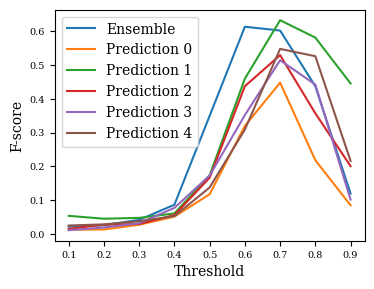

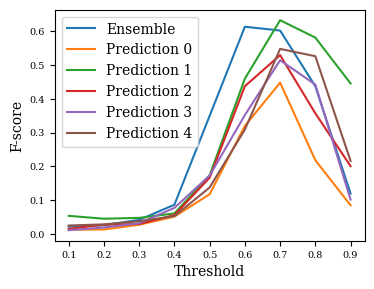

In [7]:
sample_rate = 22050
root_dir = '/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_{}Hz/Validation_Set/'.format(sample_rate)
csv_paths_me = glob.glob(os.path.join(root_dir, 'ME/*.csv'))
csv_paths_pb = glob.glob(os.path.join(root_dir, 'PB/*.csv'))
csv_paths_hb = glob.glob(os.path.join(root_dir, 'HB/*.csv'))
csv_paths = csv_paths_me + csv_paths_hb + csv_paths_pb

configs = [
    {
        'thrs'               : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'runs'               : [0,1,2,3,4],
        'tfs'                : ['tf_pcen_biodiversity'],
        'adaptive_embedding' : True,
        'stats_group'        : 0,
        'label'              : 'Ensemble',
        'experiment_dir'     : '../experiments/final_ensemble/',
        'hop_size_fraction'  : 2,
    },
    {
        'thrs'               : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'runs'               : [0],
        'tfs'                : ['tf_pcen_biodiversity'],
        'adaptive_embedding' : True,
        'stats_group'        : 0,
        'label'              : 'Prediction 0',
        'experiment_dir'     : '../experiments/final_ensemble/',
        'hop_size_fraction'  : 2,
    },
    {
        'thrs'               : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'runs'               : [1],
        'tfs'                : ['tf_pcen_biodiversity'],
        'adaptive_embedding' : True,
        'stats_group'        : 0,
        'label'              : 'Prediction 1',
        'experiment_dir'     : '../experiments/final_ensemble/',
        'hop_size_fraction'  : 2,
    },
    {
        'thrs'               : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'runs'               : [2],
        'tfs'                : ['tf_pcen_biodiversity'],
        'adaptive_embedding' : True,
        'stats_group'        : 0,
        'label'              : 'Prediction 2',
        'experiment_dir'     : '../experiments/final_ensemble/',
        'hop_size_fraction'  : 2,
    },
    {
        'thrs'               : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'runs'               : [3],
        'tfs'                : ['tf_pcen_biodiversity'],
        'adaptive_embedding' : True,
        'stats_group'        : 0,
        'label'              : 'Prediction 3',
        'experiment_dir'     : '../experiments/final_ensemble/',
        'hop_size_fraction'  : 2,
    },
    {
        'thrs'               : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'runs'               : [4],
        'tfs'                : ['tf_pcen_biodiversity'],
        'adaptive_embedding' : True,
        'stats_group'        : 0,
        'label'              : 'Prediction 4',
        'experiment_dir'     : '../experiments/final_ensemble/',
        'hop_size_fraction'  : 2,
    },

]

evaluate_and_plot(configs, csv_paths, "figure_2.pdf")

# Figure 3

/home/john/workspace/reproduce/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.13123359580052493, 'recall': 0.9615384615384616, 'fmeasure (percentage)': 23.095}
PB scores:  {'precision': 0.002084574151280524, 'recall': 0.027450980392156862, 'fmeasure (percentage)': 0.387}
HB scores:  {'precision': 0.9817518248175182, 'recall': 0.8126888217522659, 'fmeasure (percentage)': 88.926}
ME scores:  {'precision': 0.3170731707317073, 'recall': 1.0, 'fmeasure (percentage)': 48.148}
PB scores:  {'precision': 0.006300963676797628, 'recall': 0.06938775510204082, 'fmeasure (percentage)': 1.155}
HB scores:  {'precision': 0.9831460674157303, 'recall': 0.7930513595166163, 'fmeasure (percentage)': 87.793}
ME scores:  {'precision': 0.4473684210526316, 'recall': 0.9807692307692307, 'fmeasure (percentage)': 61.446}
PB scores:  {'precision': 0.007852862161603637, 'recall': 0.32340425531914896, 'fmeasure (percentage)': 1.533}
HB scores:  {'precision': 0.9718045112781954, 'recall': 0.7809667673716012, 'fmeasure (percentage)': 86.6}
ME scores:  {'precision': 0.

ME scores:  {'precision': 0.7674418604651163, 'recall': 0.6346153846153846, 'fmeasure (percentage)': 69.474}
PB scores:  {'precision': 0.46153846153846156, 'recall': 0.023529411764705882, 'fmeasure (percentage)': 4.478}
HB scores:  {'precision': 0.8571428571428571, 'recall': 0.6978851963746223, 'fmeasure (percentage)': 76.936}
PCEN (bio) max f-measure = 0.6137330362568361
ME scores:  {'precision': 0.09242144177449169, 'recall': 0.9615384615384616, 'fmeasure (percentage)': 16.863}
PB scores:  {'precision': 0.0030267753201396975, 'recall': 0.050980392156862744, 'fmeasure (percentage)': 0.571}
HB scores:  {'precision': 0.9553072625698324, 'recall': 0.7749244712990937, 'fmeasure (percentage)': 85.571}
ME scores:  {'precision': 0.2897727272727273, 'recall': 0.9807692307692307, 'fmeasure (percentage)': 44.737}
PB scores:  {'precision': 0.017671517671517672, 'recall': 0.068, 'fmeasure (percentage)': 2.805}
HB scores:  {'precision': 0.9544592030360531, 'recall': 0.7598187311178247, 'fmeasure (

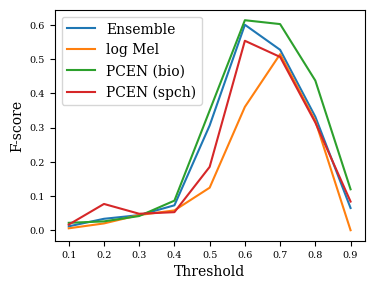

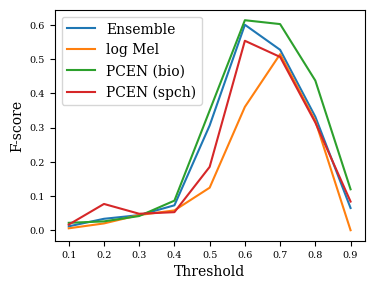

In [8]:
sample_rate = 22050
root_dir = '/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_{}Hz/Validation_Set/'.format(sample_rate)
csv_paths_me = glob.glob(os.path.join(root_dir, 'ME/*.csv'))
csv_paths_pb = glob.glob(os.path.join(root_dir, 'PB/*.csv'))
csv_paths_hb = glob.glob(os.path.join(root_dir, 'HB/*.csv'))
csv_paths = csv_paths_me + csv_paths_hb + csv_paths_pb

configs = [
    {
        'thrs'               : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'runs'               : [0,1,2,3,4],
        'tfs'                : ['tf_decibel', 'tf_pcen_biodiversity', 'tf_pcen_speech'],
        'adaptive_embedding' : True,
        'stats_group'        : 0,
        'label'              : 'Ensemble',
        'experiment_dir'     : '../experiments/final_ensemble/',
        'hop_size_fraction'  : 2,
    },
    {
        'thrs'               : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'runs'               : [0,1,2,3,4],
        'tfs'                : ['tf_decibel'],
        'adaptive_embedding' : True,
        'stats_group'        : 1,
        'label'              : 'log Mel',
        'experiment_dir'     : '../experiments/final_ensemble/',
        'hop_size_fraction'  : 2,
    },
    {
        'thrs'               : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'runs'               : [0,1,2,3,4],
        'tfs'                : ['tf_pcen_biodiversity'],
        'adaptive_embedding' : True,
        'stats_group'        : 1,
        'label'              : 'PCEN (bio)',
        'experiment_dir'     : '../experiments/final_ensemble/',
        'hop_size_fraction'  : 2,
    },
    {
        'thrs'               : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'runs'               : [0,1,2,3,4],
        'tfs'                : ['tf_pcen_speech'],
        'adaptive_embedding' : True,
        'stats_group'        : 1,
        'label'              : 'PCEN (spch)',
        'experiment_dir'     : '../experiments/final_ensemble/',
        'hop_size_fraction'  : 2,

    }
]

evaluate_and_plot(configs, csv_paths, "figure_3.pdf")

# Figure 4

/home/john/workspace/reproduce/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.13123359580052493, 'recall': 0.9615384615384616, 'fmeasure (percentage)': 23.095}
PB scores:  {'precision': 0.002084574151280524, 'recall': 0.027450980392156862, 'fmeasure (percentage)': 0.387}
HB scores:  {'precision': 0.9817518248175182, 'recall': 0.8126888217522659, 'fmeasure (percentage)': 88.926}
ME scores:  {'precision': 0.3170731707317073, 'recall': 1.0, 'fmeasure (percentage)': 48.148}
PB scores:  {'precision': 0.006300963676797628, 'recall': 0.06938775510204082, 'fmeasure (percentage)': 1.155}
HB scores:  {'precision': 0.9831460674157303, 'recall': 0.7930513595166163, 'fmeasure (percentage)': 87.793}
ME scores:  {'precision': 0.4473684210526316, 'recall': 0.9807692307692307, 'fmeasure (percentage)': 61.446}
PB scores:  {'precision': 0.007852862161603637, 'recall': 0.32340425531914896, 'fmeasure (percentage)': 1.533}
HB scores:  {'precision': 0.9718045112781954, 'recall': 0.7809667673716012, 'fmeasure (percentage)': 86.6}
ME scores:  {'precision': 0.

ME scores:  {'precision': 0.9473684210526315, 'recall': 0.34615384615384615, 'fmeasure (percentage)': 50.704}
PB scores:  {'precision': 0.7368421052631579, 'recall': 0.056, 'fmeasure (percentage)': 10.409}
HB scores:  {'precision': 0.6107594936708861, 'recall': 0.2893553223388306, 'fmeasure (percentage)': 39.268}
T/sr = 0.19 [s] max f-measure = 0.5300949781355319
ME scores:  {'precision': 0.2, 'recall': 0.6153846153846154, 'fmeasure (percentage)': 30.189}
PB scores:  {'precision': 0.014492753623188406, 'recall': 0.008, 'fmeasure (percentage)': 1.031}
HB scores:  {'precision': 0.9795501022494888, 'recall': 0.7235649546827795, 'fmeasure (percentage)': 83.232}
ME scores:  {'precision': 0.31932773109243695, 'recall': 0.7307692307692307, 'fmeasure (percentage)': 44.444}
PB scores:  {'precision': 0.01092896174863388, 'recall': 0.0163265306122449, 'fmeasure (percentage)': 1.309}
HB scores:  {'precision': 0.9578754578754579, 'recall': 0.7900302114803626, 'fmeasure (percentage)': 86.589}
ME sco

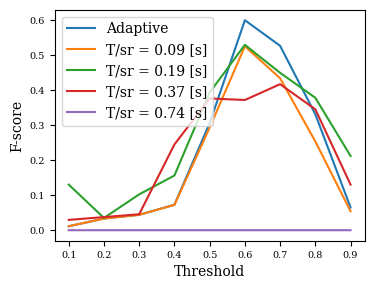

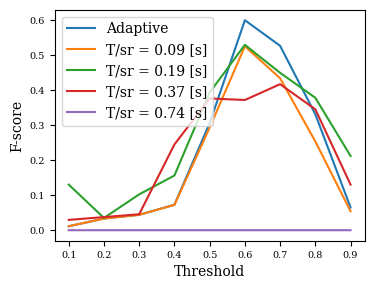

In [9]:
sample_rate = 22050
root_dir = '/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_{}Hz/Validation_Set/'.format(sample_rate)
csv_paths_me = glob.glob(os.path.join(root_dir, 'ME/*.csv'))
csv_paths_pb = glob.glob(os.path.join(root_dir, 'PB/*.csv'))
csv_paths_hb = glob.glob(os.path.join(root_dir, 'HB/*.csv'))
csv_paths = csv_paths_me + csv_paths_hb + csv_paths_pb

configs = [
    {
        'thrs'               : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'runs'               : [0,1,2,3,4],
        'tfs'                : ['tf_decibel', 'tf_pcen_biodiversity', 'tf_pcen_speech'],
        'adaptive_embedding' : True,
        'stats_group'        : 0,
        'label'              : 'Adaptive',
        'experiment_dir'     : '../experiments/final_ensemble/',
        'hop_size_fraction'  : 2,

    },
    {
        'thrs'               : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'runs'               : [0,1,2,3,4],
        'tfs'                : ['tf_decibel', 'tf_pcen_biodiversity', 'tf_pcen_speech'],
        'adaptive_embedding' : False,
        'window_size'        : 2048,
        'stats_group'        : 0,
        'label'              : 'T/sr = {:.2f} [s]'.format(2048/22050),
        'experiment_dir'     : '../experiments/final_ensemble/',
        'hop_size_fraction'  : 2,

    },
    {
        'thrs'               : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'runs'               : [0,1,2,3,4],
        'tfs'                : ['tf_decibel', 'tf_pcen_biodiversity', 'tf_pcen_speech'],
        'adaptive_embedding' : False,
        'window_size'        : 4096,
        'stats_group'        : 0,
        'label'              : 'T/sr = {:.2f} [s]'.format(4096/22050),
        'experiment_dir'     : '../experiments/final_ensemble/',
        'hop_size_fraction'  : 2,

    },
    {
        'thrs'               : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'runs'               : [0,1,2,3,4],
        'tfs'                : ['tf_decibel', 'tf_pcen_biodiversity', 'tf_pcen_speech'],
        'adaptive_embedding' : False,
        'window_size'        : 8192,
        'stats_group'        : 0,
        'label'              : 'T/sr = {:.2f} [s]'.format(8192/22050),
        'experiment_dir'     : '../experiments/final_ensemble/',
        'hop_size_fraction'  : 2,

    },
    {
        'thrs'               : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'runs'               : [0,1,2,3,4],
        'tfs'                : ['tf_decibel', 'tf_pcen_biodiversity', 'tf_pcen_speech'],
        'adaptive_embedding' : False,
        'window_size'        : 16384,
        'stats_group'        : 0,
        'label'              : 'T/sr = {:.2f} [s]'.format(16384/22050),
        'experiment_dir'     : '../experiments/final_ensemble/',
        'hop_size_fraction'  : 2,

    },
]

evaluate_and_plot(configs, csv_paths, "figure_4.pdf")

/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs
No handles with labels found to put in legend.
/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs
No handles with labels found to put in legend.
/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

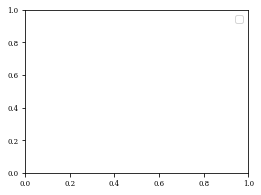

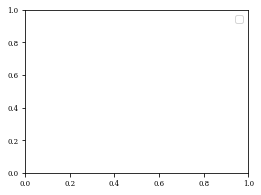

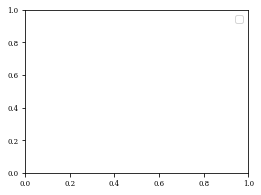

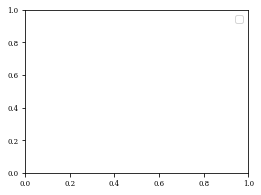

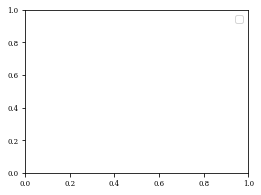

In [19]:
root_dir = '/mnt/storage_1/datasets/bioacoustics_dcase2022/Evaluation_Set_22050Hz/'
#root_dir = '/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_22050Hz/Validation_Set/'

run_evaluation = False
csv_paths = glob.glob(os.path.join(root_dir, '*/*.csv'))

martinsson_1 = {
    'thrs'               : [0.6],
    'runs'               : [0,1,2,3,4],
    'tfs'                : ['tf_decibel', 'tf_pcen_biodiversity', 'tf_pcen_speech'],
    'adaptive_embedding' : True,
    'stats_group'        : 0,
    'label'              : 'Ensemble all TF',
    'experiment_dir'     : '../experiments/final_ensemble/',
    'hop_size_fraction'  : 2,
}

evaluate_and_plot([martinsson_1], csv_paths, "dummy.pdf", prediction_path='Martinsson_RISE_task5_1.output.csv', run_evaluation=run_evaluation)

martinsson_2 = {
    'thrs'               : [0.5],
    'runs'               : [0,1,2,3,4],
    'tfs'                : ['tf_decibel', 'tf_pcen_biodiversity', 'tf_pcen_speech'],
    'adaptive_embedding' : True,
    'stats_group'        : 0,
    'label'              : 'Ensemble all TF',
    'experiment_dir'     : '../experiments/final_ensemble/',
    'hop_size_fraction'  : 2,
}

evaluate_and_plot([martinsson_2], csv_paths, "dummy.pdf", prediction_path='Martinsson_RISE_task5_2.output.csv', run_evaluation=run_evaluation)

martinsson_3 = {
    'thrs'               : [0.6],
    'runs'               : [0],
    'tfs'                : ['tf_pcen_speech'],
    'adaptive_embedding' : True,
    'stats_group'        : 0,
    'label'              : 'Ensemble all TF',
    'experiment_dir'     : '../experiments/final_ensemble/',
    'hop_size_fraction'  : 2,
}

evaluate_and_plot([martinsson_3], csv_paths, "dummy.pdf", prediction_path='Martinsson_RISE_task5_3.output.csv', run_evaluation=run_evaluation)


martinsson_4 = {
    'thrs'               : [0.5],
    'runs'               : [0],
    'tfs'                : ['tf_pcen_speech'],
    'adaptive_embedding' : True,
    'stats_group'        : 0,
    'label'              : 'Ensemble all TF',
    'experiment_dir'     : '../experiments/final_ensemble/',
    'hop_size_fraction'  : 2,
}

evaluate_and_plot([martinsson_4], csv_paths, "dummy.pdf", prediction_path='Martinsson_RISE_task5_4.output.csv', run_evaluation=run_evaluation)

# Other results

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.26737967914438504, 'recall': 0.9615384615384616, 'fmeasure (percentage)': 41.841}
PB scores:  {'precision': 0.005844155844155844, 'recall': 0.072, 'fmeasure (percentage)': 1.081}
HB scores:  {'precision': 0.9744318181818182, 'recall': 0.5142428785607196, 'fmeasure (percentage)': 67.321}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.4380952380952381, 'recall': 0.8846153846153846, 'fmeasure (percentage)': 58.599}
PB scores:  {'precision': 0.013775290572535515, 'recall': 0.2612244897959184, 'fmeasure (percentage)': 2.617}
HB scores:  {'precision': 0.872072072072072, 'recall': 0.7311178247734139, 'fmeasure (percentage)': 79.54}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.4888888888888889, 'recall': 0.8461538461538461, 'fmeasure (percentage)': 61.972}
PB scores:  {'precision': 0.013495072024260804, 'recall': 0.37872340425531914, 'fmeasure (percentage)': 2.606}
HB scores:  {'precision': 0.8136200716845878, 'recall': 0.6858006042296072, 'fmeasure (percentage)': 74.426}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.5185185185185185, 'recall': 0.8076923076923077, 'fmeasure (percentage)': 63.158}
PB scores:  {'precision': 0.008538612664349403, 'recall': 0.4808510638297872, 'fmeasure (percentage)': 1.678}
HB scores:  {'precision': 0.7705544933078394, 'recall': 0.6087613293051359, 'fmeasure (percentage)': 68.017}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.547945205479452, 'recall': 0.7692307692307693, 'fmeasure (percentage)': 64.0}
PB scores:  {'precision': 0.026608051827857474, 'recall': 0.48936170212765956, 'fmeasure (percentage)': 5.047}
HB scores:  {'precision': 0.7263157894736842, 'recall': 0.5211480362537765, 'fmeasure (percentage)': 60.686}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.5735294117647058, 'recall': 0.75, 'fmeasure (percentage)': 65.0}
PB scores:  {'precision': 0.18546845124282982, 'recall': 0.4127659574468085, 'fmeasure (percentage)': 25.594}
HB scores:  {'precision': 0.669047619047619, 'recall': 0.4244712990936556, 'fmeasure (percentage)': 51.941}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.6190476190476191, 'recall': 0.75, 'fmeasure (percentage)': 67.826}
PB scores:  {'precision': 0.6428571428571429, 'recall': 0.2938775510204082, 'fmeasure (percentage)': 40.336}
HB scores:  {'precision': 0.6055555555555555, 'recall': 0.3268365817091454, 'fmeasure (percentage)': 42.454}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.6129032258064516, 'recall': 0.7307692307692307, 'fmeasure (percentage)': 66.667}
PB scores:  {'precision': 0.7432432432432432, 'recall': 0.22, 'fmeasure (percentage)': 33.951}
HB scores:  {'precision': 0.5327510917030568, 'recall': 0.18154761904761904, 'fmeasure (percentage)': 27.081}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.5714285714285714, 'recall': 0.6153846153846154, 'fmeasure (percentage)': 59.259}
PB scores:  {'precision': 0.7560975609756098, 'recall': 0.124, 'fmeasure (percentage)': 21.306}
HB scores:  {'precision': 0.40540540540540543, 'recall': 0.08670520231213873, 'fmeasure (percentage)': 14.286}
Prediction 0 max f-measure = 0.4755088962166319


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.04940711462450593, 'recall': 0.9615384615384616, 'fmeasure (percentage)': 9.398}
PB scores:  {'precision': 0.0031272552321385616, 'recall': 0.050980392156862744, 'fmeasure (percentage)': 0.589}
HB scores:  {'precision': 0.9368421052631579, 'recall': 0.6671664167916042, 'fmeasure (percentage)': 77.933}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.22127659574468084, 'recall': 1.0, 'fmeasure (percentage)': 36.237}
PB scores:  {'precision': 0.006708760852407261, 'recall': 0.068, 'fmeasure (percentage)': 1.221}
HB scores:  {'precision': 0.8665413533834586, 'recall': 0.6963746223564955, 'fmeasure (percentage)': 77.219}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.35374149659863946, 'recall': 1.0, 'fmeasure (percentage)': 52.261}
PB scores:  {'precision': 0.005434079441066115, 'recall': 0.17872340425531916, 'fmeasure (percentage)': 1.055}
HB scores:  {'precision': 0.8156312625250501, 'recall': 0.6148036253776435, 'fmeasure (percentage)': 70.112}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.40476190476190477, 'recall': 0.9807692307692307, 'fmeasure (percentage)': 57.303}
PB scores:  {'precision': 0.006773196554218452, 'recall': 0.43829787234042555, 'fmeasure (percentage)': 1.334}
HB scores:  {'precision': 0.7635574837310195, 'recall': 0.5317220543806647, 'fmeasure (percentage)': 62.689}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.43478260869565216, 'recall': 0.9615384615384616, 'fmeasure (percentage)': 59.88}
PB scores:  {'precision': 0.015108834827144686, 'recall': 0.502127659574468, 'fmeasure (percentage)': 2.933}
HB scores:  {'precision': 0.7181372549019608, 'recall': 0.4425981873111782, 'fmeasure (percentage)': 54.766}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.494949494949495, 'recall': 0.9423076923076923, 'fmeasure (percentage)': 64.901}
PB scores:  {'precision': 0.06090979182729375, 'recall': 0.33617021276595743, 'fmeasure (percentage)': 10.313}
HB scores:  {'precision': 0.6424731182795699, 'recall': 0.3610271903323263, 'fmeasure (percentage)': 46.228}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.5348837209302325, 'recall': 0.8846153846153846, 'fmeasure (percentage)': 66.667}
PB scores:  {'precision': 0.569620253164557, 'recall': 0.19148936170212766, 'fmeasure (percentage)': 28.662}
HB scores:  {'precision': 0.567741935483871, 'recall': 0.2638680659670165, 'fmeasure (percentage)': 36.029}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.5733333333333334, 'recall': 0.8269230769230769, 'fmeasure (percentage)': 67.717}
PB scores:  {'precision': 0.5161290322580645, 'recall': 0.064, 'fmeasure (percentage)': 11.388}
HB scores:  {'precision': 0.4858490566037736, 'recall': 0.15327380952380953, 'fmeasure (percentage)': 23.303}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.6031746031746031, 'recall': 0.7307692307692307, 'fmeasure (percentage)': 66.087}
PB scores:  {'precision': 0.5, 'recall': 0.027450980392156862, 'fmeasure (percentage)': 5.204}
HB scores:  {'precision': 0.4380952380952381, 'recall': 0.06695778748180495, 'fmeasure (percentage)': 11.616}
Prediction 1 max f-measure = 0.38637601736740684


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.02873204247345409, 'recall': 0.8846153846153846, 'fmeasure (percentage)': 5.566}
PB scores:  {'precision': 0.0013422818791946308, 'recall': 0.011764705882352941, 'fmeasure (percentage)': 0.241}
HB scores:  {'precision': 0.9512195121951219, 'recall': 0.5847076461769115, 'fmeasure (percentage)': 72.423}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.08617594254937164, 'recall': 0.9230769230769231, 'fmeasure (percentage)': 15.764}
PB scores:  {'precision': 0.0049504950495049506, 'recall': 0.08163265306122448, 'fmeasure (percentage)': 0.933}
HB scores:  {'precision': 0.8386524822695035, 'recall': 0.7145015105740181, 'fmeasure (percentage)': 77.162}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.27976190476190477, 'recall': 0.9038461538461539, 'fmeasure (percentage)': 42.727}
PB scores:  {'precision': 0.006935758953951108, 'recall': 0.25957446808510637, 'fmeasure (percentage)': 1.351}
HB scores:  {'precision': 0.7749077490774908, 'recall': 0.6344410876132931, 'fmeasure (percentage)': 69.767}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.4, 'recall': 0.8846153846153846, 'fmeasure (percentage)': 55.09}
PB scores:  {'precision': 0.007155262243834665, 'recall': 0.43829787234042555, 'fmeasure (percentage)': 1.408}
HB scores:  {'precision': 0.7109375, 'recall': 0.5498489425981873, 'fmeasure (percentage)': 62.01}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.5056179775280899, 'recall': 0.8653846153846154, 'fmeasure (percentage)': 63.83}
PB scores:  {'precision': 0.014855460385438972, 'recall': 0.4723404255319149, 'fmeasure (percentage)': 2.88}
HB scores:  {'precision': 0.6324435318275154, 'recall': 0.4652567975830816, 'fmeasure (percentage)': 53.612}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.6081081081081081, 'recall': 0.8653846153846154, 'fmeasure (percentage)': 71.429}
PB scores:  {'precision': 0.06843455945252352, 'recall': 0.3404255319148936, 'fmeasure (percentage)': 11.396}
HB scores:  {'precision': 0.5596707818930041, 'recall': 0.4108761329305136, 'fmeasure (percentage)': 47.387}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.6470588235294118, 'recall': 0.8461538461538461, 'fmeasure (percentage)': 73.333}
PB scores:  {'precision': 0.5510204081632653, 'recall': 0.22040816326530613, 'fmeasure (percentage)': 31.487}
HB scores:  {'precision': 0.5246305418719212, 'recall': 0.3193403298350825, 'fmeasure (percentage)': 39.702}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.6842105263157895, 'recall': 0.75, 'fmeasure (percentage)': 71.56}
PB scores:  {'precision': 0.6052631578947368, 'recall': 0.092, 'fmeasure (percentage)': 15.972}
HB scores:  {'precision': 0.4473684210526316, 'recall': 0.15292353823088456, 'fmeasure (percentage)': 22.793}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.8, 'recall': 0.6923076923076923, 'fmeasure (percentage)': 74.227}
PB scores:  {'precision': 0.6666666666666666, 'recall': 0.00784313725490196, 'fmeasure (percentage)': 1.55}
HB scores:  {'precision': 0.34210526315789475, 'recall': 0.019202363367799114, 'fmeasure (percentage)': 3.636}
Prediction 2 max f-measure = 0.42502901620372324


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.13054830287206268, 'recall': 0.9615384615384616, 'fmeasure (percentage)': 22.989}
PB scores:  {'precision': 0.002136181575433912, 'recall': 0.03137254901960784, 'fmeasure (percentage)': 0.4}
HB scores:  {'precision': 0.9350912778904665, 'recall': 0.6911544227886057, 'fmeasure (percentage)': 79.483}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.22857142857142856, 'recall': 0.9230769230769231, 'fmeasure (percentage)': 36.641}
PB scores:  {'precision': 0.005647840531561462, 'recall': 0.068, 'fmeasure (percentage)': 1.043}
HB scores:  {'precision': 0.8574007220216606, 'recall': 0.7175226586102719, 'fmeasure (percentage)': 78.125}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.3146853146853147, 'recall': 0.8653846153846154, 'fmeasure (percentage)': 46.154}
PB scores:  {'precision': 0.004012247914686939, 'recall': 0.16170212765957448, 'fmeasure (percentage)': 0.783}
HB scores:  {'precision': 0.842911877394636, 'recall': 0.6646525679758308, 'fmeasure (percentage)': 74.324}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.3728813559322034, 'recall': 0.8461538461538461, 'fmeasure (percentage)': 51.765}
PB scores:  {'precision': 0.006609593352637543, 'recall': 0.44680851063829785, 'fmeasure (percentage)': 1.303}
HB scores:  {'precision': 0.7987679671457906, 'recall': 0.5876132930513596, 'fmeasure (percentage)': 67.711}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.4095238095238095, 'recall': 0.8269230769230769, 'fmeasure (percentage)': 54.777}
PB scores:  {'precision': 0.018419777023751818, 'recall': 0.4851063829787234, 'fmeasure (percentage)': 3.549}
HB scores:  {'precision': 0.7349137931034483, 'recall': 0.5151057401812689, 'fmeasure (percentage)': 60.568}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.44680851063829785, 'recall': 0.8076923076923077, 'fmeasure (percentage)': 57.534}
PB scores:  {'precision': 0.10152284263959391, 'recall': 0.3404255319148936, 'fmeasure (percentage)': 15.64}
HB scores:  {'precision': 0.7040572792362768, 'recall': 0.44227886056971516, 'fmeasure (percentage)': 54.328}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.4523809523809524, 'recall': 0.7307692307692307, 'fmeasure (percentage)': 55.882}
PB scores:  {'precision': 0.4020618556701031, 'recall': 0.16595744680851063, 'fmeasure (percentage)': 23.494}
HB scores:  {'precision': 0.6442048517520216, 'recall': 0.3583208395802099, 'fmeasure (percentage)': 46.05}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.47435897435897434, 'recall': 0.7115384615384616, 'fmeasure (percentage)': 56.923}
PB scores:  {'precision': 0.4444444444444444, 'recall': 0.03137254901960784, 'fmeasure (percentage)': 5.861}
HB scores:  {'precision': 0.5719844357976653, 'recall': 0.22038980509745126, 'fmeasure (percentage)': 31.818}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.5151515151515151, 'recall': 0.6538461538461539, 'fmeasure (percentage)': 57.627}
PB scores:  {'precision': 0.5714285714285714, 'recall': 0.01568627450980392, 'fmeasure (percentage)': 3.053}
HB scores:  {'precision': 0.4327485380116959, 'recall': 0.10930576070901034, 'fmeasure (percentage)': 17.453}
Prediction 3 max f-measure = 0.365077554509417


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.0843585237258348, 'recall': 0.9230769230769231, 'fmeasure (percentage)': 15.459}
PB scores:  {'precision': 0.004352557127312296, 'recall': 0.06274509803921569, 'fmeasure (percentage)': 0.814}
HB scores:  {'precision': 0.9656652360515021, 'recall': 0.6746626686656672, 'fmeasure (percentage)': 79.435}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.22274881516587677, 'recall': 0.9038461538461539, 'fmeasure (percentage)': 35.741}
PB scores:  {'precision': 0.0053526448362720405, 'recall': 0.06938775510204082, 'fmeasure (percentage)': 0.994}
HB scores:  {'precision': 0.8690702087286527, 'recall': 0.6918429003021148, 'fmeasure (percentage)': 77.04}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.38016528925619836, 'recall': 0.8846153846153846, 'fmeasure (percentage)': 53.179}
PB scores:  {'precision': 0.00516366989396035, 'recall': 0.23829787234042554, 'fmeasure (percentage)': 1.011}
HB scores:  {'precision': 0.7959558823529411, 'recall': 0.6540785498489426, 'fmeasure (percentage)': 71.808}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.44, 'recall': 0.8461538461538461, 'fmeasure (percentage)': 57.895}
PB scores:  {'precision': 0.00764244285226885, 'recall': 0.4765957446808511, 'fmeasure (percentage)': 1.504}
HB scores:  {'precision': 0.7543859649122807, 'recall': 0.5845921450151057, 'fmeasure (percentage)': 65.872}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.48863636363636365, 'recall': 0.8269230769230769, 'fmeasure (percentage)': 61.429}
PB scores:  {'precision': 0.02463382157123835, 'recall': 0.4723404255319149, 'fmeasure (percentage)': 4.683}
HB scores:  {'precision': 0.6757322175732218, 'recall': 0.4879154078549849, 'fmeasure (percentage)': 56.667}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.525, 'recall': 0.8076923076923077, 'fmeasure (percentage)': 63.636}
PB scores:  {'precision': 0.17716535433070865, 'recall': 0.3829787234042553, 'fmeasure (percentage)': 24.226}
HB scores:  {'precision': 0.6256038647342995, 'recall': 0.39123867069486407, 'fmeasure (percentage)': 48.141}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.525, 'recall': 0.8076923076923077, 'fmeasure (percentage)': 63.636}
PB scores:  {'precision': 0.5377358490566038, 'recall': 0.2375, 'fmeasure (percentage)': 32.948}
HB scores:  {'precision': 0.5766871165644172, 'recall': 0.2818590704647676, 'fmeasure (percentage)': 37.865}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.5428571428571428, 'recall': 0.7307692307692307, 'fmeasure (percentage)': 62.295}
PB scores:  {'precision': 0.6111111111111112, 'recall': 0.08979591836734693, 'fmeasure (percentage)': 15.658}
HB scores:  {'precision': 0.4828897338403042, 'recall': 0.18898809523809523, 'fmeasure (percentage)': 27.166}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.5178571428571429, 'recall': 0.5576923076923077, 'fmeasure (percentage)': 53.704}
PB scores:  {'precision': 0.5625, 'recall': 0.03529411764705882, 'fmeasure (percentage)': 6.642}
HB scores:  {'precision': 0.36075949367088606, 'recall': 0.08357771260997067, 'fmeasure (percentage)': 13.571}
Prediction 4 max f-measure = 0.41393733991235127


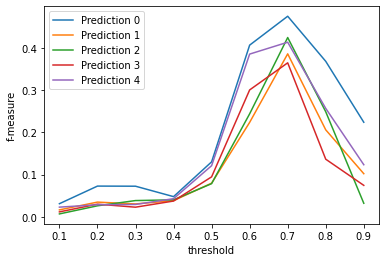

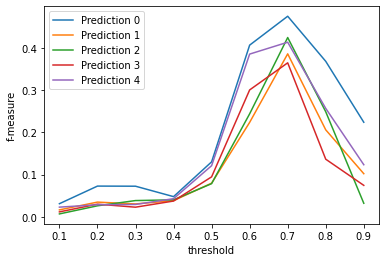

In [20]:
sample_rate = 22050
root_dir = '/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_{}Hz/Validation_Set/'.format(sample_rate)
csv_paths_me = glob.glob(os.path.join(root_dir, 'ME/*.csv'))
csv_paths_pb = glob.glob(os.path.join(root_dir, 'PB/*.csv'))
csv_paths_hb = glob.glob(os.path.join(root_dir, 'HB/*.csv'))
csv_paths = csv_paths_me + csv_paths_hb + csv_paths_pb

configs = [
    {
        'thrs'               : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'runs'               : [0],
        'tfs'                : ['tf_pcen_speech'],
        'adaptive_embedding' : False,
        'window_size'        : 2048,
        'stats_group'        : 0,
        'label'              : 'Prediction 0',
        'experiment_dir'     : '../experiments/final_ensemble/',
        'hop_size_fraction'  : 2,

    },
    {
        'thrs'               : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'runs'               : [1],
        'tfs'                : ['tf_pcen_speech'],
        'adaptive_embedding' : False,
        'window_size'        : 2048,
        'stats_group'        : 0,
        'label'              : 'Prediction 1',
        'experiment_dir'     : '../experiments/final_ensemble/',
        'hop_size_fraction'  : 2,

    },
    {
        'thrs'               : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'runs'               : [2],
        'tfs'                : ['tf_pcen_speech'],
        'adaptive_embedding' : False,
        'window_size'        : 2048,
        'stats_group'        : 0,
        'label'              : 'Prediction 2',
        'experiment_dir'     : '../experiments/final_ensemble/',
        'hop_size_fraction'  : 2,

    },
    {
        'thrs'               : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'runs'               : [3],
        'tfs'                : ['tf_pcen_speech'],
        'adaptive_embedding' : False,
        'window_size'        : 2048,
        'stats_group'        : 0,
        'label'              : 'Prediction 3',
        'experiment_dir'     : '../experiments/final_ensemble/',
        'hop_size_fraction'  : 2,

    },
    {
        'thrs'               : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'runs'               : [4],
        'tfs'                : ['tf_pcen_speech'],
        'adaptive_embedding' : False,
        'window_size'        : 2048,
        'stats_group'        : 0,
        'label'              : 'Prediction 4',
        'experiment_dir'     : '../experiments/final_ensemble/',
        'hop_size_fraction'  : 2,

    },
]

evaluate_and_plot(configs)

In [24]:
print(np.mean([0.4755088962166319,0.38637601736740684,0.42502901620372324,0.365077554509417,0.41393733991235127]))
print(np.std([0.4755088962166319,0.38637601736740684,0.42502901620372324,0.365077554509417,0.41393733991235127]))

0.41318576484190606
0.03757169847983575


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.26737967914438504, 'recall': 0.9615384615384616, 'fmeasure (percentage)': 41.841}
PB scores:  {'precision': 0.005844155844155844, 'recall': 0.072, 'fmeasure (percentage)': 1.081}
HB scores:  {'precision': 0.9150090415913201, 'recall': 0.7643504531722054, 'fmeasure (percentage)': 83.292}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.4380952380952381, 'recall': 0.8846153846153846, 'fmeasure (percentage)': 58.599}
PB scores:  {'precision': 0.013775290572535515, 'recall': 0.2612244897959184, 'fmeasure (percentage)': 2.617}
HB scores:  {'precision': 0.9007220216606499, 'recall': 0.7537764350453172, 'fmeasure (percentage)': 82.072}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.4888888888888889, 'recall': 0.8461538461538461, 'fmeasure (percentage)': 61.972}
PB scores:  {'precision': 0.013495072024260804, 'recall': 0.37872340425531914, 'fmeasure (percentage)': 2.606}
HB scores:  {'precision': 0.9009174311926605, 'recall': 0.7416918429003021, 'fmeasure (percentage)': 81.359}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.5185185185185185, 'recall': 0.8076923076923077, 'fmeasure (percentage)': 63.158}
PB scores:  {'precision': 0.008538612664349403, 'recall': 0.4808510638297872, 'fmeasure (percentage)': 1.678}
HB scores:  {'precision': 0.8937728937728938, 'recall': 0.7371601208459214, 'fmeasure (percentage)': 80.795}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.547945205479452, 'recall': 0.7692307692307693, 'fmeasure (percentage)': 64.0}
PB scores:  {'precision': 0.026608051827857474, 'recall': 0.48936170212765956, 'fmeasure (percentage)': 5.047}
HB scores:  {'precision': 0.8673835125448028, 'recall': 0.7311178247734139, 'fmeasure (percentage)': 79.344}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.5735294117647058, 'recall': 0.75, 'fmeasure (percentage)': 65.0}
PB scores:  {'precision': 0.18546845124282982, 'recall': 0.4127659574468085, 'fmeasure (percentage)': 25.594}
HB scores:  {'precision': 0.8528368794326241, 'recall': 0.7265861027190332, 'fmeasure (percentage)': 78.467}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.6190476190476191, 'recall': 0.75, 'fmeasure (percentage)': 67.826}
PB scores:  {'precision': 0.6428571428571429, 'recall': 0.2938775510204082, 'fmeasure (percentage)': 40.336}
HB scores:  {'precision': 0.8353765323992994, 'recall': 0.7205438066465257, 'fmeasure (percentage)': 77.372}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.6129032258064516, 'recall': 0.7307692307692307, 'fmeasure (percentage)': 66.667}
PB scores:  {'precision': 0.7432432432432432, 'recall': 0.22, 'fmeasure (percentage)': 33.951}
HB scores:  {'precision': 0.8027210884353742, 'recall': 0.7129909365558912, 'fmeasure (percentage)': 75.52}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.5714285714285714, 'recall': 0.6153846153846154, 'fmeasure (percentage)': 59.259}
PB scores:  {'precision': 0.7560975609756098, 'recall': 0.124, 'fmeasure (percentage)': 21.306}
HB scores:  {'precision': 0.7889273356401384, 'recall': 0.6888217522658611, 'fmeasure (percentage)': 73.548}
Prediction 0 max f-measure = 0.5718666243983976


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.04940711462450593, 'recall': 0.9615384615384616, 'fmeasure (percentage)': 9.398}
PB scores:  {'precision': 0.0031272552321385616, 'recall': 0.050980392156862744, 'fmeasure (percentage)': 0.589}
HB scores:  {'precision': 0.9237918215613383, 'recall': 0.7507552870090635, 'fmeasure (percentage)': 82.833}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.22127659574468084, 'recall': 1.0, 'fmeasure (percentage)': 36.237}
PB scores:  {'precision': 0.006708760852407261, 'recall': 0.068, 'fmeasure (percentage)': 1.221}
HB scores:  {'precision': 0.9124767225325885, 'recall': 0.7401812688821753, 'fmeasure (percentage)': 81.735}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.35374149659863946, 'recall': 1.0, 'fmeasure (percentage)': 52.261}
PB scores:  {'precision': 0.005434079441066115, 'recall': 0.17872340425531916, 'fmeasure (percentage)': 1.055}
HB scores:  {'precision': 0.8846153846153846, 'recall': 0.729607250755287, 'fmeasure (percentage)': 79.967}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.40476190476190477, 'recall': 0.9807692307692307, 'fmeasure (percentage)': 57.303}
PB scores:  {'precision': 0.006773196554218452, 'recall': 0.43829787234042555, 'fmeasure (percentage)': 1.334}
HB scores:  {'precision': 0.8754578754578755, 'recall': 0.7220543806646526, 'fmeasure (percentage)': 79.139}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.43478260869565216, 'recall': 0.9615384615384616, 'fmeasure (percentage)': 59.88}
PB scores:  {'precision': 0.015108834827144686, 'recall': 0.502127659574468, 'fmeasure (percentage)': 2.933}
HB scores:  {'precision': 0.875, 'recall': 0.7190332326283988, 'fmeasure (percentage)': 78.939}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.494949494949495, 'recall': 0.9423076923076923, 'fmeasure (percentage)': 64.901}
PB scores:  {'precision': 0.06090979182729375, 'recall': 0.33617021276595743, 'fmeasure (percentage)': 10.313}
HB scores:  {'precision': 0.8655616942909761, 'recall': 0.7099697885196374, 'fmeasure (percentage)': 78.008}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.5348837209302325, 'recall': 0.8846153846153846, 'fmeasure (percentage)': 66.667}
PB scores:  {'precision': 0.569620253164557, 'recall': 0.19148936170212766, 'fmeasure (percentage)': 28.662}
HB scores:  {'precision': 0.8539741219963032, 'recall': 0.6978851963746223, 'fmeasure (percentage)': 76.808}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.5733333333333334, 'recall': 0.8269230769230769, 'fmeasure (percentage)': 67.717}
PB scores:  {'precision': 0.5161290322580645, 'recall': 0.064, 'fmeasure (percentage)': 11.388}
HB scores:  {'precision': 0.825136612021858, 'recall': 0.6842900302114804, 'fmeasure (percentage)': 74.814}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.6031746031746031, 'recall': 0.7307692307692307, 'fmeasure (percentage)': 66.087}
PB scores:  {'precision': 0.5, 'recall': 0.027450980392156862, 'fmeasure (percentage)': 5.204}
HB scores:  {'precision': 0.7985739750445633, 'recall': 0.676737160120846, 'fmeasure (percentage)': 73.262}
Prediction 1 max f-measure = 0.47688408207269095


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.02873204247345409, 'recall': 0.8846153846153846, 'fmeasure (percentage)': 5.566}
PB scores:  {'precision': 0.0013422818791946308, 'recall': 0.011764705882352941, 'fmeasure (percentage)': 0.241}
HB scores:  {'precision': 0.9382022471910112, 'recall': 0.756797583081571, 'fmeasure (percentage)': 83.779}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.08617594254937164, 'recall': 0.9230769230769231, 'fmeasure (percentage)': 15.764}
PB scores:  {'precision': 0.0049504950495049506, 'recall': 0.08163265306122448, 'fmeasure (percentage)': 0.933}
HB scores:  {'precision': 0.9183673469387755, 'recall': 0.7477341389728097, 'fmeasure (percentage)': 82.431}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.27976190476190477, 'recall': 0.9038461538461539, 'fmeasure (percentage)': 42.727}
PB scores:  {'precision': 0.006935758953951108, 'recall': 0.25957446808510637, 'fmeasure (percentage)': 1.351}
HB scores:  {'precision': 0.9094269870609981, 'recall': 0.743202416918429, 'fmeasure (percentage)': 81.796}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.4, 'recall': 0.8846153846153846, 'fmeasure (percentage)': 55.09}
PB scores:  {'precision': 0.007155262243834665, 'recall': 0.43829787234042555, 'fmeasure (percentage)': 1.408}
HB scores:  {'precision': 0.8909090909090909, 'recall': 0.7401812688821753, 'fmeasure (percentage)': 80.858}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.5056179775280899, 'recall': 0.8653846153846154, 'fmeasure (percentage)': 63.83}
PB scores:  {'precision': 0.014855460385438972, 'recall': 0.4723404255319149, 'fmeasure (percentage)': 2.88}
HB scores:  {'precision': 0.8747731397459165, 'recall': 0.7280966767371602, 'fmeasure (percentage)': 79.472}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.6081081081081081, 'recall': 0.8653846153846154, 'fmeasure (percentage)': 71.429}
PB scores:  {'precision': 0.06843455945252352, 'recall': 0.3404255319148936, 'fmeasure (percentage)': 11.396}
HB scores:  {'precision': 0.8584392014519057, 'recall': 0.7145015105740181, 'fmeasure (percentage)': 77.988}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.6470588235294118, 'recall': 0.8461538461538461, 'fmeasure (percentage)': 73.333}
PB scores:  {'precision': 0.5510204081632653, 'recall': 0.22040816326530613, 'fmeasure (percentage)': 31.487}
HB scores:  {'precision': 0.8336314847942755, 'recall': 0.7039274924471299, 'fmeasure (percentage)': 76.331}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.6842105263157895, 'recall': 0.75, 'fmeasure (percentage)': 71.56}
PB scores:  {'precision': 0.6052631578947368, 'recall': 0.092, 'fmeasure (percentage)': 15.972}
HB scores:  {'precision': 0.7961335676625659, 'recall': 0.6842900302114804, 'fmeasure (percentage)': 73.599}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.8, 'recall': 0.6923076923076923, 'fmeasure (percentage)': 74.227}
PB scores:  {'precision': 0.6666666666666666, 'recall': 0.00784313725490196, 'fmeasure (percentage)': 1.55}
HB scores:  {'precision': 0.7564322469982847, 'recall': 0.6661631419939577, 'fmeasure (percentage)': 70.843}
Prediction 2 max f-measure = 0.5128513604816188


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.13054830287206268, 'recall': 0.9615384615384616, 'fmeasure (percentage)': 22.989}
PB scores:  {'precision': 0.002136181575433912, 'recall': 0.03137254901960784, 'fmeasure (percentage)': 0.4}
HB scores:  {'precision': 0.949438202247191, 'recall': 0.7658610271903323, 'fmeasure (percentage)': 84.783}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.22857142857142856, 'recall': 0.9230769230769231, 'fmeasure (percentage)': 36.641}
PB scores:  {'precision': 0.005647840531561462, 'recall': 0.068, 'fmeasure (percentage)': 1.043}
HB scores:  {'precision': 0.9342105263157895, 'recall': 0.7507552870090635, 'fmeasure (percentage)': 83.25}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.3146853146853147, 'recall': 0.8653846153846154, 'fmeasure (percentage)': 46.154}
PB scores:  {'precision': 0.004012247914686939, 'recall': 0.16170212765957448, 'fmeasure (percentage)': 0.783}
HB scores:  {'precision': 0.9199255121042831, 'recall': 0.7462235649546828, 'fmeasure (percentage)': 82.402}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.3728813559322034, 'recall': 0.8461538461538461, 'fmeasure (percentage)': 51.765}
PB scores:  {'precision': 0.006609593352637543, 'recall': 0.44680851063829785, 'fmeasure (percentage)': 1.303}
HB scores:  {'precision': 0.8964879852125693, 'recall': 0.7326283987915407, 'fmeasure (percentage)': 80.632}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.4095238095238095, 'recall': 0.8269230769230769, 'fmeasure (percentage)': 54.777}
PB scores:  {'precision': 0.018419777023751818, 'recall': 0.4851063829787234, 'fmeasure (percentage)': 3.549}
HB scores:  {'precision': 0.8892988929889298, 'recall': 0.7280966767371602, 'fmeasure (percentage)': 80.066}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.44680851063829785, 'recall': 0.8076923076923077, 'fmeasure (percentage)': 57.534}
PB scores:  {'precision': 0.10152284263959391, 'recall': 0.3404255319148936, 'fmeasure (percentage)': 15.64}
HB scores:  {'precision': 0.8659420289855072, 'recall': 0.7220543806646526, 'fmeasure (percentage)': 78.748}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.4523809523809524, 'recall': 0.7307692307692307, 'fmeasure (percentage)': 55.882}
PB scores:  {'precision': 0.4020618556701031, 'recall': 0.16595744680851063, 'fmeasure (percentage)': 23.494}
HB scores:  {'precision': 0.8386524822695035, 'recall': 0.7145015105740181, 'fmeasure (percentage)': 77.162}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.47435897435897434, 'recall': 0.7115384615384616, 'fmeasure (percentage)': 56.923}
PB scores:  {'precision': 0.4444444444444444, 'recall': 0.03137254901960784, 'fmeasure (percentage)': 5.861}
HB scores:  {'precision': 0.8110918544194108, 'recall': 0.7069486404833837, 'fmeasure (percentage)': 75.545}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.5151515151515151, 'recall': 0.6538461538461539, 'fmeasure (percentage)': 57.627}
PB scores:  {'precision': 0.5714285714285714, 'recall': 0.01568627450980392, 'fmeasure (percentage)': 3.053}
HB scores:  {'precision': 0.7818499127399651, 'recall': 0.676737160120846, 'fmeasure (percentage)': 72.551}
Prediction 3 max f-measure = 0.40861540924728934


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.0843585237258348, 'recall': 0.9230769230769231, 'fmeasure (percentage)': 15.459}
PB scores:  {'precision': 0.004352557127312296, 'recall': 0.06274509803921569, 'fmeasure (percentage)': 0.814}
HB scores:  {'precision': 0.9512195121951219, 'recall': 0.7658610271903323, 'fmeasure (percentage)': 84.854}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.22274881516587677, 'recall': 0.9038461538461539, 'fmeasure (percentage)': 35.741}
PB scores:  {'precision': 0.0053526448362720405, 'recall': 0.06938775510204082, 'fmeasure (percentage)': 0.994}
HB scores:  {'precision': 0.9401869158878504, 'recall': 0.7598187311178247, 'fmeasure (percentage)': 84.043}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.38016528925619836, 'recall': 0.8846153846153846, 'fmeasure (percentage)': 53.179}
PB scores:  {'precision': 0.00516366989396035, 'recall': 0.23829787234042554, 'fmeasure (percentage)': 1.011}
HB scores:  {'precision': 0.9275092936802974, 'recall': 0.7537764350453172, 'fmeasure (percentage)': 83.167}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.44, 'recall': 0.8461538461538461, 'fmeasure (percentage)': 57.895}
PB scores:  {'precision': 0.00764244285226885, 'recall': 0.4765957446808511, 'fmeasure (percentage)': 1.504}
HB scores:  {'precision': 0.894927536231884, 'recall': 0.7462235649546828, 'fmeasure (percentage)': 81.384}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.48863636363636365, 'recall': 0.8269230769230769, 'fmeasure (percentage)': 61.429}
PB scores:  {'precision': 0.02463382157123835, 'recall': 0.4723404255319149, 'fmeasure (percentage)': 4.683}
HB scores:  {'precision': 0.8817204301075269, 'recall': 0.743202416918429, 'fmeasure (percentage)': 80.656}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.525, 'recall': 0.8076923076923077, 'fmeasure (percentage)': 63.636}
PB scores:  {'precision': 0.17716535433070865, 'recall': 0.3829787234042553, 'fmeasure (percentage)': 24.226}
HB scores:  {'precision': 0.8812949640287769, 'recall': 0.7401812688821753, 'fmeasure (percentage)': 80.46}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.525, 'recall': 0.8076923076923077, 'fmeasure (percentage)': 63.636}
PB scores:  {'precision': 0.5377358490566038, 'recall': 0.2375, 'fmeasure (percentage)': 32.948}
HB scores:  {'precision': 0.875, 'recall': 0.729607250755287, 'fmeasure (percentage)': 79.572}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.5428571428571428, 'recall': 0.7307692307692307, 'fmeasure (percentage)': 62.295}
PB scores:  {'precision': 0.6111111111111112, 'recall': 0.08979591836734693, 'fmeasure (percentage)': 15.658}
HB scores:  {'precision': 0.8509874326750448, 'recall': 0.716012084592145, 'fmeasure (percentage)': 77.769}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.5178571428571429, 'recall': 0.5576923076923077, 'fmeasure (percentage)': 53.704}
PB scores:  {'precision': 0.5625, 'recall': 0.03529411764705882, 'fmeasure (percentage)': 6.642}
HB scores:  {'precision': 0.8131672597864769, 'recall': 0.6903323262839879, 'fmeasure (percentage)': 74.673}
Prediction 4 max f-measure = 0.5116620514059509


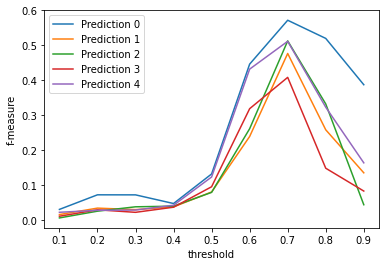

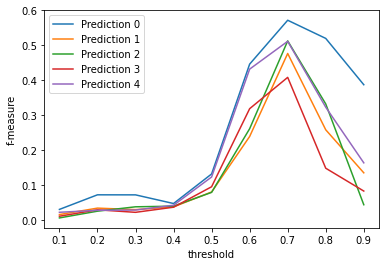

In [54]:
sample_rate = 22050
root_dir = '/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_{}Hz/Validation_Set/'.format(sample_rate)
csv_paths_me = glob.glob(os.path.join(root_dir, 'ME/*.csv'))
csv_paths_pb = glob.glob(os.path.join(root_dir, 'PB/*.csv'))
csv_paths_hb = glob.glob(os.path.join(root_dir, 'HB/*.csv'))
csv_paths = csv_paths_me + csv_paths_hb + csv_paths_pb

configs = [
    {
        'thrs'               : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'runs'               : [0],
        'tfs'                : ['tf_pcen_speech'],
        'adaptive_embedding' : True,
        'window_size'        : 2048,
        'stats_group'        : 0,
        'label'              : 'Prediction 0',
        'experiment_dir'     : '../experiments/final_ensemble/',
        'hop_size_fraction'  : 2,

    },
    {
        'thrs'               : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'runs'               : [1],
        'tfs'                : ['tf_pcen_speech'],
        'adaptive_embedding' : True,
        'window_size'        : 2048,
        'stats_group'        : 0,
        'label'              : 'Prediction 1',
        'experiment_dir'     : '../experiments/final_ensemble/',
        'hop_size_fraction'  : 2,

    },
    {
        'thrs'               : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'runs'               : [2],
        'tfs'                : ['tf_pcen_speech'],
        'adaptive_embedding' : True,
        'window_size'        : 2048,
        'stats_group'        : 0,
        'label'              : 'Prediction 2',
        'experiment_dir'     : '../experiments/final_ensemble/',
        'hop_size_fraction'  : 2,

    },
    {
        'thrs'               : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'runs'               : [3],
        'tfs'                : ['tf_pcen_speech'],
        'adaptive_embedding' : True,
        'window_size'        : 2048,
        'stats_group'        : 0,
        'label'              : 'Prediction 3',
        'experiment_dir'     : '../experiments/final_ensemble/',
        'hop_size_fraction'  : 2,

    },
    {
        'thrs'               : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'runs'               : [4],
        'tfs'                : ['tf_pcen_speech'],
        'adaptive_embedding' : True,
        'window_size'        : 2048,
        'stats_group'        : 0,
        'label'              : 'Prediction 4',
        'experiment_dir'     : '../experiments/final_ensemble/',
        'hop_size_fraction'  : 2,

    },
]

evaluate_and_plot(configs, csv_paths)

In [57]:
print(np.mean([0.5718666243983976, 0.47688408207269095, 0.5128513604816188, 0.40861540924728934, 0.5116620514059509]))
print(np.std([0.5718666243983976, 0.47688408207269095, 0.5128513604816188, 0.40861540924728934, 0.5116620514059509]))

0.4963759055211895
0.053452392643079494


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.408, 'recall': 0.9807692307692307, 'fmeasure (percentage)': 57.627}
PB scores:  {'precision': 0.09574468085106383, 'recall': 0.036, 'fmeasure (percentage)': 5.233}
HB scores:  {'precision': 0.9817518248175182, 'recall': 0.8126888217522659, 'fmeasure (percentage)': 88.926}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.5294117647058824, 'recall': 0.8653846153846154, 'fmeasure (percentage)': 65.693}
PB scores:  {'precision': 0.006094702297233943, 'recall': 0.10833333333333334, 'fmeasure (percentage)': 1.154}
HB scores:  {'precision': 0.9831460674157303, 'recall': 0.7930513595166163, 'fmeasure (percentage)': 87.793}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.639344262295082, 'recall': 0.75, 'fmeasure (percentage)': 69.027}
PB scores:  {'precision': 0.010975393875022128, 'recall': 0.26382978723404255, 'fmeasure (percentage)': 2.107}
HB scores:  {'precision': 0.9718045112781954, 'recall': 0.7809667673716012, 'fmeasure (percentage)': 86.6}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.68, 'recall': 0.6538461538461539, 'fmeasure (percentage)': 66.667}
PB scores:  {'precision': 0.01060806971017238, 'recall': 0.23829787234042554, 'fmeasure (percentage)': 2.031}
HB scores:  {'precision': 0.9622641509433962, 'recall': 0.770392749244713, 'fmeasure (percentage)': 85.57}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.7804878048780488, 'recall': 0.6153846153846154, 'fmeasure (percentage)': 68.817}
PB scores:  {'precision': 0.0671892497200448, 'recall': 0.2553191489361702, 'fmeasure (percentage)': 10.638}
HB scores:  {'precision': 0.9386617100371747, 'recall': 0.7628398791540786, 'fmeasure (percentage)': 84.167}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.8285714285714286, 'recall': 0.5576923076923077, 'fmeasure (percentage)': 66.667}
PB scores:  {'precision': 0.47761194029850745, 'recall': 0.2723404255319149, 'fmeasure (percentage)': 34.688}
HB scores:  {'precision': 0.9185185185185185, 'recall': 0.7492447129909365, 'fmeasure (percentage)': 82.529}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.9285714285714286, 'recall': 0.5, 'fmeasure (percentage)': 65.0}
PB scores:  {'precision': 0.6833333333333333, 'recall': 0.17083333333333334, 'fmeasure (percentage)': 27.333}
HB scores:  {'precision': 0.8950276243093923, 'recall': 0.7341389728096677, 'fmeasure (percentage)': 80.664}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.9523809523809523, 'recall': 0.38461538461538464, 'fmeasure (percentage)': 54.795}
PB scores:  {'precision': 0.75, 'recall': 0.132, 'fmeasure (percentage)': 22.449}
HB scores:  {'precision': 0.8467153284671532, 'recall': 0.7009063444108762, 'fmeasure (percentage)': 76.694}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.9473684210526315, 'recall': 0.34615384615384615, 'fmeasure (percentage)': 50.704}
PB scores:  {'precision': 0.7368421052631579, 'recall': 0.056, 'fmeasure (percentage)': 10.409}
HB scores:  {'precision': 0.7988826815642458, 'recall': 0.648036253776435, 'fmeasure (percentage)': 71.56}
Ensemble (large) max f-measure = 0.5362403711878914


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.3067484662576687, 'recall': 0.9615384615384616, 'fmeasure (percentage)': 46.512}
PB scores:  {'precision': 0.027210884353741496, 'recall': 0.03137254901960784, 'fmeasure (percentage)': 2.914}
HB scores:  {'precision': 0.9812734082397003, 'recall': 0.7915407854984894, 'fmeasure (percentage)': 87.625}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.4782608695652174, 'recall': 0.8461538461538461, 'fmeasure (percentage)': 61.111}
PB scores:  {'precision': 0.013569937369519834, 'recall': 0.052, 'fmeasure (percentage)': 2.152}
HB scores:  {'precision': 0.9869402985074627, 'recall': 0.7990936555891238, 'fmeasure (percentage)': 88.314}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.5671641791044776, 'recall': 0.7307692307692307, 'fmeasure (percentage)': 63.866}
PB scores:  {'precision': 0.01253616200578592, 'recall': 0.1625, 'fmeasure (percentage)': 2.328}
HB scores:  {'precision': 0.975609756097561, 'recall': 0.7854984894259819, 'fmeasure (percentage)': 87.029}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.6226415094339622, 'recall': 0.6346153846153846, 'fmeasure (percentage)': 62.857}
PB scores:  {'precision': 0.008534211708339573, 'recall': 0.2425531914893617, 'fmeasure (percentage)': 1.649}
HB scores:  {'precision': 0.9586466165413534, 'recall': 0.770392749244713, 'fmeasure (percentage)': 85.427}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.7435897435897436, 'recall': 0.5576923076923077, 'fmeasure (percentage)': 63.736}
PB scores:  {'precision': 0.05465949820788531, 'recall': 0.25957446808510637, 'fmeasure (percentage)': 9.03}
HB scores:  {'precision': 0.9328358208955224, 'recall': 0.7552870090634441, 'fmeasure (percentage)': 83.472}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.7878787878787878, 'recall': 0.5, 'fmeasure (percentage)': 61.176}
PB scores:  {'precision': 0.7032967032967034, 'recall': 0.2723404255319149, 'fmeasure (percentage)': 39.264}
HB scores:  {'precision': 0.9216417910447762, 'recall': 0.7462235649546828, 'fmeasure (percentage)': 82.471}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.875, 'recall': 0.40384615384615385, 'fmeasure (percentage)': 55.263}
PB scores:  {'precision': 0.7727272727272727, 'recall': 0.136, 'fmeasure (percentage)': 23.129}
HB scores:  {'precision': 0.8813868613138686, 'recall': 0.729607250755287, 'fmeasure (percentage)': 79.835}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.9473684210526315, 'recall': 0.34615384615384615, 'fmeasure (percentage)': 50.704}
PB scores:  {'precision': 0.6190476190476191, 'recall': 0.052, 'fmeasure (percentage)': 9.594}
HB scores:  {'precision': 0.8375912408759124, 'recall': 0.6933534743202417, 'fmeasure (percentage)': 75.868}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 1.0, 'recall': 0.28846153846153844, 'fmeasure (percentage)': 44.776}
PB scores:  {'precision': 1.0, 'recall': 0.011764705882352941, 'fmeasure (percentage)': 2.326}
HB scores:  {'precision': 0.7752808988764045, 'recall': 0.6253776435045317, 'fmeasure (percentage)': 69.231}
Ensemble (small) max f-measure = 0.5561692995109594


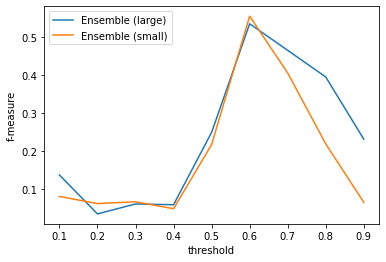

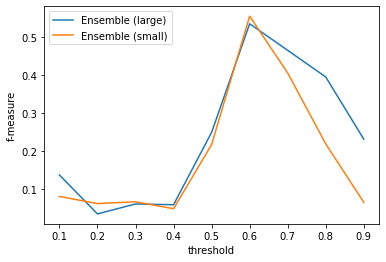

In [46]:
sample_rate = 22050
root_dir = '/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_{}Hz/Validation_Set/'.format(sample_rate)
csv_paths_me = glob.glob(os.path.join(root_dir, 'ME/*.csv'))
csv_paths_pb = glob.glob(os.path.join(root_dir, 'PB/*.csv'))
csv_paths_hb = glob.glob(os.path.join(root_dir, 'HB/*.csv'))
csv_paths = csv_paths_me + csv_paths_hb + csv_paths_pb

configs = [
    {
        'thrs'               : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'runs'               : [0,1,2,3,4],
        'tfs'                : ['tf_decibel', 'tf_pcen_biodiversity', 'tf_pcen_speech'],
        'adaptive_embedding' : True,
        'stats_group'        : 0,
        'label'              : 'Ensemble (large)',
        'experiment_dir'     : '../experiments/final_ensemble/',
    },
    {
        'thrs'               : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'runs'               : [0,1,2,3,4],
        'tfs'                : ['tf_decibel', 'tf_pcen_biodiversity', 'tf_pcen_speech'],
        'adaptive_embedding' : True,
        'stats_group'        : 0,
        'label'              : 'Ensemble (small)',
        'experiment_dir'     : '../experiments/final_ensemble_small/',
    },
]

evaluate_and_plot(configs)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.408, 'recall': 0.9807692307692307, 'fmeasure (percentage)': 57.627}
PB scores:  {'precision': 0.09574468085106383, 'recall': 0.036, 'fmeasure (percentage)': 5.233}
HB scores:  {'precision': 0.9817518248175182, 'recall': 0.8126888217522659, 'fmeasure (percentage)': 88.926}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.5294117647058824, 'recall': 0.8653846153846154, 'fmeasure (percentage)': 65.693}
PB scores:  {'precision': 0.006094702297233943, 'recall': 0.10833333333333334, 'fmeasure (percentage)': 1.154}
HB scores:  {'precision': 0.9831460674157303, 'recall': 0.7930513595166163, 'fmeasure (percentage)': 87.793}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.639344262295082, 'recall': 0.75, 'fmeasure (percentage)': 69.027}
PB scores:  {'precision': 0.010975393875022128, 'recall': 0.26382978723404255, 'fmeasure (percentage)': 2.107}
HB scores:  {'precision': 0.9718045112781954, 'recall': 0.7809667673716012, 'fmeasure (percentage)': 86.6}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.68, 'recall': 0.6538461538461539, 'fmeasure (percentage)': 66.667}
PB scores:  {'precision': 0.01060806971017238, 'recall': 0.23829787234042554, 'fmeasure (percentage)': 2.031}
HB scores:  {'precision': 0.9622641509433962, 'recall': 0.770392749244713, 'fmeasure (percentage)': 85.57}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.7804878048780488, 'recall': 0.6153846153846154, 'fmeasure (percentage)': 68.817}
PB scores:  {'precision': 0.0671892497200448, 'recall': 0.2553191489361702, 'fmeasure (percentage)': 10.638}
HB scores:  {'precision': 0.9386617100371747, 'recall': 0.7628398791540786, 'fmeasure (percentage)': 84.167}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.8285714285714286, 'recall': 0.5576923076923077, 'fmeasure (percentage)': 66.667}
PB scores:  {'precision': 0.47761194029850745, 'recall': 0.2723404255319149, 'fmeasure (percentage)': 34.688}
HB scores:  {'precision': 0.9185185185185185, 'recall': 0.7492447129909365, 'fmeasure (percentage)': 82.529}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.9285714285714286, 'recall': 0.5, 'fmeasure (percentage)': 65.0}
PB scores:  {'precision': 0.6833333333333333, 'recall': 0.17083333333333334, 'fmeasure (percentage)': 27.333}
HB scores:  {'precision': 0.8950276243093923, 'recall': 0.7341389728096677, 'fmeasure (percentage)': 80.664}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.9523809523809523, 'recall': 0.38461538461538464, 'fmeasure (percentage)': 54.795}
PB scores:  {'precision': 0.75, 'recall': 0.132, 'fmeasure (percentage)': 22.449}
HB scores:  {'precision': 0.8467153284671532, 'recall': 0.7009063444108762, 'fmeasure (percentage)': 76.694}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.9473684210526315, 'recall': 0.34615384615384615, 'fmeasure (percentage)': 50.704}
PB scores:  {'precision': 0.7368421052631579, 'recall': 0.056, 'fmeasure (percentage)': 10.409}
HB scores:  {'precision': 0.7988826815642458, 'recall': 0.648036253776435, 'fmeasure (percentage)': 71.56}
Ensemble max f-measure = 0.5362403711878914


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.3923076923076923, 'recall': 0.9807692307692307, 'fmeasure (percentage)': 56.044}
PB scores:  {'precision': 0.061855670103092786, 'recall': 0.023529411764705882, 'fmeasure (percentage)': 3.409}
HB scores:  {'precision': 0.9853211009174312, 'recall': 0.8111782477341389, 'fmeasure (percentage)': 88.981}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.5227272727272727, 'recall': 0.8846153846153846, 'fmeasure (percentage)': 65.714}
PB scores:  {'precision': 0.005397070161912105, 'recall': 0.058333333333333334, 'fmeasure (percentage)': 0.988}
HB scores:  {'precision': 0.9869646182495344, 'recall': 0.8006042296072508, 'fmeasure (percentage)': 88.407}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.625, 'recall': 0.7692307692307693, 'fmeasure (percentage)': 68.966}
PB scores:  {'precision': 0.010824853864472829, 'recall': 0.2127659574468085, 'fmeasure (percentage)': 2.06}
HB scores:  {'precision': 0.9830508474576272, 'recall': 0.7885196374622356, 'fmeasure (percentage)': 87.51}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.68, 'recall': 0.6538461538461539, 'fmeasure (percentage)': 66.667}
PB scores:  {'precision': 0.009061114324272219, 'recall': 0.2, 'fmeasure (percentage)': 1.734}
HB scores:  {'precision': 0.9736842105263158, 'recall': 0.7824773413897281, 'fmeasure (percentage)': 86.767}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.7441860465116279, 'recall': 0.6153846153846154, 'fmeasure (percentage)': 67.368}
PB scores:  {'precision': 0.043859649122807015, 'recall': 0.2127659574468085, 'fmeasure (percentage)': 7.273}
HB scores:  {'precision': 0.9659735349716446, 'recall': 0.7719033232628398, 'fmeasure (percentage)': 85.81}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.8108108108108109, 'recall': 0.5769230769230769, 'fmeasure (percentage)': 67.416}
PB scores:  {'precision': 0.38620689655172413, 'recall': 0.23829787234042554, 'fmeasure (percentage)': 29.474}
HB scores:  {'precision': 0.9420560747663551, 'recall': 0.7613293051359517, 'fmeasure (percentage)': 84.211}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.9032258064516129, 'recall': 0.5384615384615384, 'fmeasure (percentage)': 67.47}
PB scores:  {'precision': 0.6545454545454545, 'recall': 0.15, 'fmeasure (percentage)': 24.407}
HB scores:  {'precision': 0.9253731343283582, 'recall': 0.7492447129909365, 'fmeasure (percentage)': 82.805}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.9166666666666666, 'recall': 0.4230769230769231, 'fmeasure (percentage)': 57.895}
PB scores:  {'precision': 0.7142857142857143, 'recall': 0.12, 'fmeasure (percentage)': 20.548}
HB scores:  {'precision': 0.8844036697247707, 'recall': 0.7280966767371602, 'fmeasure (percentage)': 79.867}


/home/john/gits/dcase-bioacoustics-2022/post_processing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Group'] = gs


ME scores:  {'precision': 0.95, 'recall': 0.36538461538461536, 'fmeasure (percentage)': 52.778}
PB scores:  {'precision': 0.7368421052631579, 'recall': 0.056, 'fmeasure (percentage)': 10.409}
HB scores:  {'precision': 0.8183453237410072, 'recall': 0.6873111782477341, 'fmeasure (percentage)': 74.713}
Ensemble (hop size small) max f-measure = 0.4947482085010307


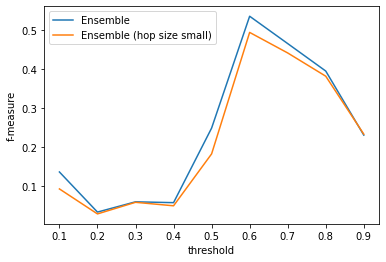

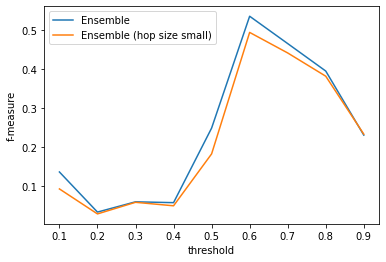

In [7]:
sample_rate = 22050
root_dir = '/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_{}Hz/Validation_Set/'.format(sample_rate)
csv_paths_me = glob.glob(os.path.join(root_dir, 'ME/*.csv'))
csv_paths_pb = glob.glob(os.path.join(root_dir, 'PB/*.csv'))
csv_paths_hb = glob.glob(os.path.join(root_dir, 'HB/*.csv'))
csv_paths = csv_paths_me + csv_paths_hb + csv_paths_pb

configs = [
    {
        'thrs'               : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'runs'               : [0,1,2,3,4],
        'tfs'                : ['tf_decibel', 'tf_pcen_biodiversity', 'tf_pcen_speech'],
        'adaptive_embedding' : True,
        'stats_group'        : 0,
        'label'              : 'Ensemble',
        'experiment_dir'     : '../experiments/final_ensemble/',
        'hop_size_fraction'  : 2,
    },
    {
        'thrs'               : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'runs'               : [0,1,2,3,4],
        'tfs'                : ['tf_decibel', 'tf_pcen_biodiversity', 'tf_pcen_speech'],
        'adaptive_embedding' : True,
        'stats_group'        : 0,
        'label'              : 'Ensemble (hop size small)',
        'experiment_dir'     : '../experiments/final_ensemble/',
        'hop_size_fraction'  : 4,
    },
]

evaluate_and_plot(configs)